In [2]:
import medmnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers, models

dataTrain = medmnist.BreastMNIST(split="train", download=True, size=64)
dataVal   = medmnist.BreastMNIST(split="val",   download=True, size=64)
dataTest  = medmnist.BreastMNIST(split="test",  download=True, size=64)

x_train, y_train = np.array([i[0] for i in dataTrain]), np.array([i[1][0] for i in dataTrain])
x_val, y_val =  np.array([i[0] for i in dataVal]), np.array([i[1][0] for i in dataVal])
x_test, y_test =  np.array([i[0] for i in dataTest]), np.array([i[1][0] for i in dataTest])

x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [3]:
#Función usada en el otro ipynb
def modeloCustomizable(
    input_shape=(224, 224, 1), 
    num_filtros=[10, 20], 
    tamano_kernel=(5, 5), 
    capas_densas=[50], 
    dropout_rate=[0.5, 0],
    dropout_rate_final=0.5,
):
    if len(num_filtros) != len(dropout_rate):
        raise ValueError("""
            El largo de num_filtros y el de dropout_rate representan la cantidad de 
            capas convolucionales, por lo que estas listas deben tener el mismo largo.
        """)
    capas_conv = [layers.Input(shape=input_shape)]
    for i in range(len(num_filtros)):
        capas_conv.append(layers.Conv2D(num_filtros[i], tamano_kernel, activation='relu'))
        capas_conv.append(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout_rate[i] > 0:
            capas_conv.append(layers.Dropout(dropout_rate[i]))

    capas_dens = [layers.Flatten()]
    for i in capas_densas:
        capas_dens.append(layers.Dense(i, activation='relu'))
    if dropout_rate_final > 0:
        capas_dens.append(layers.Dropout(dropout_rate_final))
    capas_dens.append(layers.Dense(1, activation='sigmoid'))

    capas_total = capas_conv + capas_dens
    model = models.Sequential(capas_total)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
from tensorflow.keras.callbacks import TensorBoard

def bootstrap_sample(X, y):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    return X[idx], y[idx]

modelos = []
n_modelos = 5  # o la cantidad que quieras

for i in range(n_modelos):
    print(f"Entrenando modelo {i+1}/{n_modelos}")
    model = modeloCustomizable(
        input_shape=(64, 64, 1),
        num_filtros=[30, 30],
        tamano_kernel=(9, 9),
        capas_densas=[100]*3,
        dropout_rate=[0, 0],
        dropout_rate_final=0
    )
    X_boot, y_boot = bootstrap_sample(x_train, y_train)
    history = model.fit(
        X_boot, y_boot,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[TensorBoard(log_dir=f'logs/bagging_{i}')],
        verbose=0
    )
    print(f"Último val_accuracy del modelo: {history.history['val_accuracy'][-1]:.4f}")
    modelos.append(model)

Entrenando modelo 1/5
Último val_accuracy del modelo: 0.8462
Entrenando modelo 2/5
Último val_accuracy del modelo: 0.8846
Entrenando modelo 3/5
Último val_accuracy del modelo: 0.8333
Entrenando modelo 4/5
Último val_accuracy del modelo: 0.8462
Entrenando modelo 5/5
Último val_accuracy del modelo: 0.8718


In [5]:
preds = np.zeros((len(x_test), n_modelos))
for i, model in enumerate(modelos):
    preds[:, i] = model.predict(x_test).ravel()

# Promedio de predicciones
y_pred_bagging = (preds.mean(axis=1) > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F9C053E840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


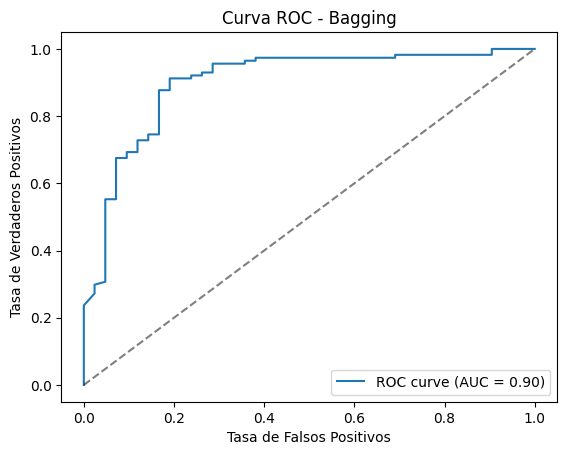

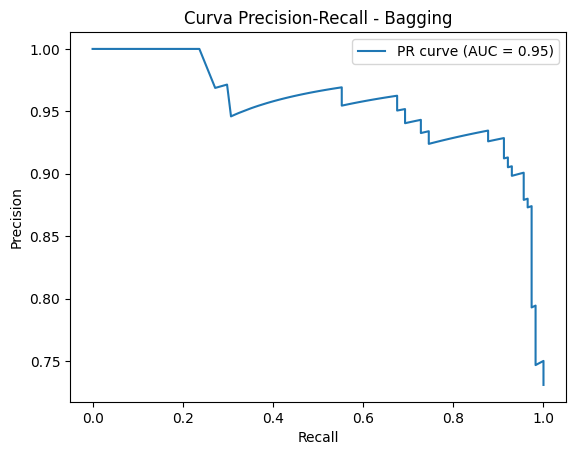

In [6]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# Probabilidades promedio del ensamble
y_score = preds.mean(axis=1)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Bagging')
plt.legend()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Bagging')
plt.legend()
plt.show()

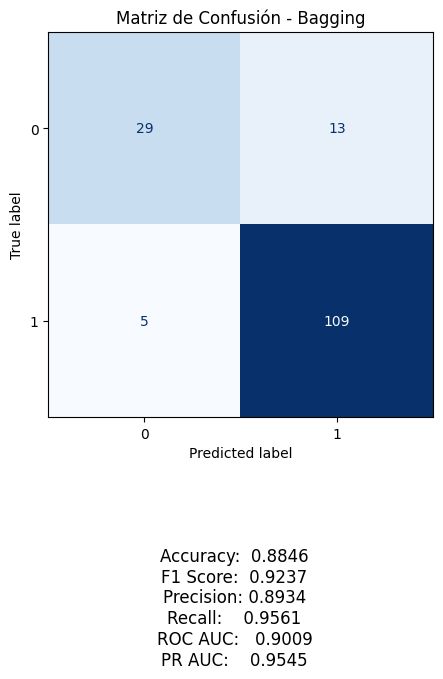

Accuracy:  0.8846
F1 Score:  0.9237
Precision: 0.8934
Recall:    0.9561
ROC AUC:   0.9009
PR AUC:    0.9545


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

# Predicción binaria final
y_pred_bagging = (preds.mean(axis=1) > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_bagging)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title("Matriz de Confusión - Bagging")

# Métricas principales
acc = accuracy_score(y_test, y_pred_bagging)
f1 = f1_score(y_test, y_pred_bagging)
prec = precision_score(y_test, y_pred_bagging)
rec = recall_score(y_test, y_pred_bagging)
roc_auc = roc_auc_score(y_test, preds.mean(axis=1))
pr_auc = average_precision_score(y_test, preds.mean(axis=1))

metrics_text = (
    f"Accuracy:  {acc:.4f}\n"
    f"F1 Score:  {f1:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall:    {rec:.4f}\n"
    f"ROC AUC:   {roc_auc:.4f}\n"
    f"PR AUC:    {pr_auc:.4f}"
)
plt.gcf().text(0.5, -0.15, metrics_text, fontsize=12, ha='center', va='top')
plt.show()
print(metrics_text)